In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
class Data:
    def __init__(self, inputData):
        self.dataSeries = inputData
        self.n = inputData.size
        
    def variational_series(self):
        variational_series = self.dataSeries.value_counts().rename_axis('x_i').reset_index(name='n_i')
        variational_series = variational_series.sort_values(['x_i'])
        variational_series['w_i'] = variational_series['n_i'].apply(lambda n_i: n_i/self.n)
        return variational_series
    
    def series_polygon(self):
        fig, ax = plt.subplots()
        ax.plot('x_i', 'w_i', data=self.variational_series(), marker='.', linewidth = 2)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('w_i')
    
    def discrete_F(self):
        xData = self.variational_series()['x_i'].tolist()
        wData = self.variational_series()['w_i'].tolist()
        result = []
        
        value = 0
        i = 0
        j = -1
        
        sheets = [f'(-inf, {xData[0]}]']
        F = [0]
        
        for x in np.linspace(xData[0], xData[-1], 100):
            if x <= xData[i]:
                result.append(value)
            else:
                sheets.append(f'({xData[i]}, {xData[i + 1]}]')
                i += 1
                j += 1
                value += wData[j]
                F.append(value)
                result.append(value)
                
        sheets.append(f'({xData[-1]}, inf)')
        F.append(1)
        df = pd.DataFrame(zip(sheets, F), columns=['interval', 'F'])
        
        return df, result
    
    
    def interval_series(self):
        xData = self.variational_series()['x_i'].tolist()
        nData = self.variational_series()['n_i'].tolist()
        
        k = 1 + 3.322 * np.log10(self.n)
        h = round((xData[-1] - xData[0]) / k, 3)
        value = xData[0] - h / 2
        
        intervalStart = []
        intervalEnd = []
        n = []
        
        while True:
            intervalStart.append(round(value, 4))
            value += h
            intervalEnd.append(round(value, 4))
            
            if value >= xData[-1]:
                break
        intervalStart[0] = xData[0]
        intervalEnd[-1] = xData[-1]
        
        n_i = 0
        for i in range(len(intervalStart)):
            for j in range(len(xData)):
                if (xData[j] >= intervalStart[i]) and (xData[j] <= intervalEnd[i]):
                    n_i += nData[j]
            n.append(n_i)
            n_i = 0
        
        df = pd.DataFrame(zip(intervalStart, intervalEnd, n), columns=['start', 'end', 'n_i'])
        df['w_i'] = df['n_i'].apply(lambda n_i: n_i/self.n)
        df['w_i/h'] = df['w_i'].apply(lambda n_i: round(n_i/h, 3))
            
        return df
    
    def interval_polygon(self):
        fig, ax = plt.subplots()
        
        xStartData = self.interval_series()['start'].tolist()
        xEndData = self.interval_series()['end'].tolist()
        wData = self.interval_series()['w_i'].tolist()
        
        x = []
        for i in range(len(xStartData)):
            x.append((xStartData[i] + xEndData[i]) / 2)
        
        ax.plot(x, wData, marker='.', linewidth = 2)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('w_i')
    
    def interval_F(self):
        xData = self.variational_series()['x_i'].tolist()
        nData = self.interval_series()['n_i'].tolist()
        intervalStart = self.interval_series()['start'].tolist()
        intervalEnd = self.interval_series()['end'].tolist()
        
        F = [0]
        value = 0
        for i in range(len(intervalEnd) - 1):
            value += nData[i] / self.n
            F.append(round(value, 4))
        F.append(1)
        
        df = pd.DataFrame(zip([intervalStart[0]] + intervalEnd, F), columns=['x', 'F'])
        
        return F, df

    def F_plot(self, mod):     
        fig, ax = plt.subplots()
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('F')
        
        if mod == 1:
            xData = self.variational_series()['x_i'].tolist()
            wData = self.variational_series()['w_i'].tolist()
            
            x = np.linspace(xData[0], xData[-1], 100)
            w = self.discrete_F()[1]
            w[0] = w[2]
            ax.plot(x, w, linewidth = 2, color='b')
            
        if mod == 2:
            xData = self.variational_series()['x_i'].tolist()
            
            x = [xData[0]] + self.interval_series()['end'].tolist()
            y = self.interval_F()[0]
            ax.plot(x, y, linewidth = 2, color='r', marker='.')
            
        if mod == 3:
            xData = self.variational_series()['x_i'].tolist()
            wData = self.variational_series()['w_i'].tolist()
            w = self.discrete_F()[1]
            x1 = np.linspace(xData[0], xData[-1], 100)
            w[0] = w[2]
            
            ax.plot(x1, w, linewidth = 2, color='b')
            
            x2 = [xData[0]] + self.interval_series()['end'].tolist()
            y = self.interval_F()[0]
            
            ax.plot(x2, y, linewidth = 2, color='r', marker='.')

    def w_histogram(self):
        intervalStart = self.interval_series()['start'].tolist()
        intervalEnd = self.interval_series()['end'].tolist()
        
        n, bins, rects = plt.hist([], bins=[intervalStart[0]] + intervalEnd, ec='k')
        
        for i in range(len(rects)):
            rects[i].set_height(self.interval_series()['w_i/h'].tolist()[i])

        plt.ylim(0, max(self.interval_series()['w_i/h'].tolist()) + 1)
        plt.show()
        

In [3]:
inputData = pd.read_csv(r'D:/kpi/Statistica/CalcAndGraphic/Work1/data.csv')
MachNumbers = Data(inputData)

In [4]:
MachNumbers.variational_series()

,x_i,n_i,w_i
6,0.56,2,0.066667
7,0.57,2,0.066667
8,0.58,2,0.066667
2,0.59,3,0.100000
0,0.60,4,0.133333
1,0.61,4,0.133333
3,0.62,3,0.100000
9,0.63,2,0.066667
4,0.64,3,0.100000
10,0.65,2,0.066667


In [5]:
MachNumbers.variational_series()['n_i'].sum(), MachNumbers.variational_series()['w_i'].sum()

(30, 1.0)

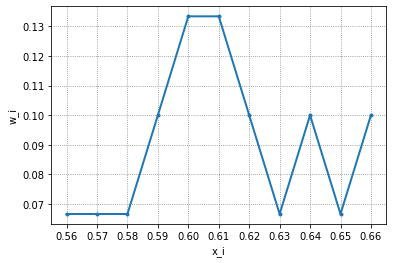

In [6]:
MachNumbers.series_polygon()

In [7]:
MachNumbers.discrete_F()[0]

,interval,F
0,"(-inf, 0.56]",0.000000
1,"(0.56, 0.57]",0.066667
2,"(0.57, 0.58]",0.133333
3,"(0.58, 0.59]",0.200000
4,"(0.59, 0.6]",0.300000
5,"(0.6, 0.61]",0.433333
6,"(0.61, 0.62]",0.566667
7,"(0.62, 0.63]",0.666667
8,"(0.63, 0.64]",0.733333
9,"(0.64, 0.65]",0.833333


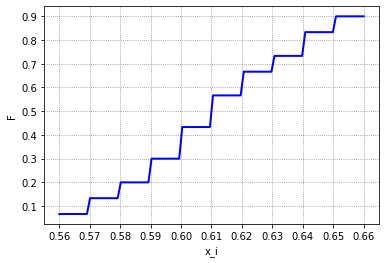

In [8]:
MachNumbers.F_plot(1)

In [9]:
MachNumbers.interval_series()

,start,end,n_i,w_i,w_i/h
0,0.5600,0.5685,2,0.066667,3.922
1,0.5685,0.5855,4,0.133333,7.843
2,0.5855,0.6025,7,0.233333,13.725
3,0.6025,0.6195,4,0.133333,7.843
4,0.6195,0.6365,5,0.166667,9.804
5,0.6365,0.6535,5,0.166667,9.804
6,0.6535,0.6600,3,0.100000,5.882


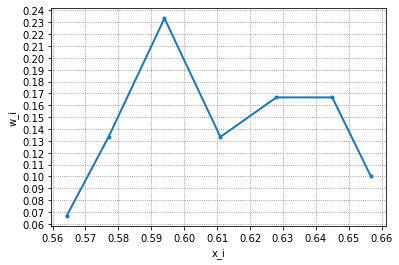

In [10]:
MachNumbers.interval_polygon()

In [11]:
MachNumbers.interval_F()[1]

,x,F
0,0.5600,0.0000
1,0.5685,0.0667
2,0.5855,0.2000
3,0.6025,0.4333
4,0.6195,0.5667
5,0.6365,0.7333
6,0.6535,0.9000
7,0.6600,1.0000


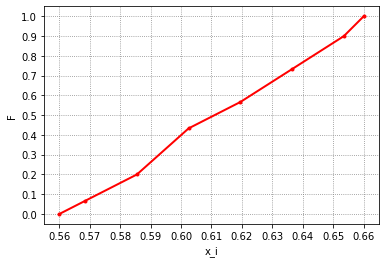

In [12]:
MachNumbers.F_plot(2)

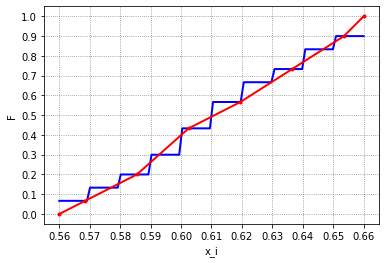

In [13]:
MachNumbers.F_plot(3)

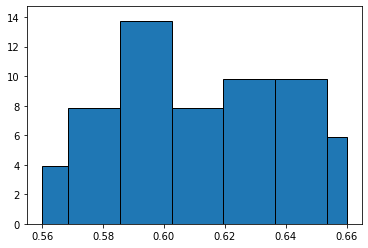

In [14]:
MachNumbers.w_histogram()